# Correlational Neural Networks with Tensorflow

![alt text](https://deeplearnschool.files.wordpress.com/2017/05/cornet.png)

# Import Modules

Import all the necessary modules for training and testing the CorrNet

In [1]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.keras as keras

# Our modules
import corrnet.data.mnist_views
import corrnet.layers
import corrnet.loss

Populating the interactive namespace from numpy and matplotlib
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Fetch and split MNIST data

left_mnist contains the left halves of images and right_mnist contains the right halves
Usage:
- left_mnist.train.images: Left images for training
- left_mnist.validation.images: Left images for validation
- left_mnist.test.images: Left images for testing

Example of a MNIST image left and right halves:
![alt text](https://deeplearnschool.files.wordpress.com/2017/05/d2.png?w=340&h=245)

In [2]:
left_mnist = corrnet.data.mnist_views.left_view_dataset()
right_mnist = corrnet.data.mnist_views.right_view_dataset()

# CorrNet and training configuration

In [7]:
n_inputs = 28*14
hdim1, hdim2, hdim = 500, 300, 50
learning_rate = 0.001
n_epochs = 40
batch_size = 100
lamda = 0.02

tf.reset_default_graph()

# Build CorrNet with tensorflow

We will build a NN with 3 encoding layers (for both modalities), 1 common layer and 1 decoding layer (for both modalities).

- The encoding layers will build a "pyramid" with decreasing hidden units (l1: 500 -> l2: 300 -> l3: 50)
- The common layer adds the output of l3 for left and right input

In [8]:
with tf.device('/gpu:1'):
    X1 = tf.placeholder(tf.float32, shape=(None,n_inputs), name='X1')
    X2 = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X2')
    keep_prob = tf.placeholder(tf.float32)

    with tf.name_scope('dnn'):
        h1_X1_l = corrnet.layers.dense_layer(X1, hdim1, name='h1_X1', activation=corrnet.activations.leaky_relu)
        h1_o = h1_X1_l.apply(X1)
        h1_X2_l = corrnet.layers.dense_layer(X2, hdim1, name='h1_X2', activation=corrnet.activations.leaky_relu)
        h2_o = h1_X2_l.apply(X2)

        h2_X1_l = corrnet.layers.dense_layer(h1_o, hdim2, name='h2_X1', activation=corrnet.activations.leaky_relu)
        h1_o = h2_X1_l.apply(h1_o)
        h2_X2_l = corrnet.layers.dense_layer(h2_o, hdim2, name='h2_X2', activation=corrnet.activations.leaky_relu)
        h2_o = h2_X2_l.apply(h2_o)

        h1_l = corrnet.layers.dense_layer(h1_o, hdim, name='h1', activation=corrnet.activations.leaky_relu)
        h1_o = h1_l(h1_o)
        h2_l = corrnet.layers.dense_layer(h2_o, hdim, name='h2', activation=corrnet.activations.leaky_relu)
        h2_o = h2_l(h2_o)
        h_l = keras.layers.Add()
        h_o = h_l([h1_o, h2_o])

        r1_X1_l = corrnet.layers.dense_layer(h_o, n_inputs, name='r1_X1', activation=corrnet.activations.leaky_relu)
        reconstruct_X1 = r1_X1_l.apply(h_o)

        r1_X2_l = corrnet.layers.dense_layer(h_o, n_inputs, name='r1_X2', activation=corrnet.activations.leaky_relu)
        reconstruct_X2 = r1_X2_l.apply(h_o)    


# Define loss, optimizer and evaluation metric

The loss function is defined as:
![alt text](https://deeplearnschool.files.wordpress.com/2017/05/eq31.png?w=640)

- We use all terms and set lambda=0.02
- Adam optimizer with learning_rate=0.001 ensures fast and stable convergence

In [9]:
with tf.device('/gpu:1'):
    with tf.name_scope('loss'):
        loss = corrnet.loss.calculate_loss(
            [h1_X1_l, h2_X1_l, h1_l],
            [h1_X2_l, h2_X2_l, h2_l],
            [r1_X1_l], [r1_X2_l],
            h_l, [X1, X2],
            ['l1', 'l2', 'l3', 'l4'], lamda=lamda)

    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss)

    with tf.name_scope('eval'):
        reconstruction_accuracy = loss

# Train model

Use minibatch training with batch_size = 100 for 40 epochs.

In [10]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

config = tf.ConfigProto(log_device_placement=True)

with tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(left_mnist.train.num_examples // batch_size):
            X_batch1, _ = left_mnist.train.next_batch(batch_size, shuffle=False)
            X_batch2, _ = right_mnist.train.next_batch(batch_size, shuffle=False)
            sess.run(train_op, feed_dict={X1: X_batch1, X2: X_batch2})
        acc_train = reconstruction_accuracy.eval(feed_dict={X1: X_batch1, X2: X_batch2})
        X_val_batch1 = left_mnist.validation.images
        X_val_batch2 = right_mnist.validation.images
        acc_validation = reconstruction_accuracy.eval(feed_dict={X1: X_val_batch1, X2: X_val_batch2})
        print('Epoch: {}\tTrain accuracy: {}\tValidation accuracy: {}'.format(epoch, acc_train, acc_validation))

    X_test1 = left_mnist.test.images
    X_test2 = right_mnist.test.images
    rec_left, rec_right = sess.run([reconstruct_X1, reconstruct_X2], feed_dict={X1: X_test1, X2: X_test2})
    rec_left_left, rec_left_right = sess.run([reconstruct_X1, reconstruct_X2], feed_dict={X1: X_test1, X2: np.zeros_like(X_test2)})
    rec_right_left, rec_right_right = sess.run([reconstruct_X1, reconstruct_X2], feed_dict={X1: np.zeros_like(X_test1), X2: X_test2})

    acc_test = reconstruction_accuracy.eval(feed_dict={X1: X_test1, X2: X_test2})
    print('Test accuracy: {}'.format(acc_test))
    save_path = saver.save(sess, './my_model_final_multi.ckpt')

Epoch: 0	Train accuracy: 0.133393570781	Validation accuracy: 7.84239006042
Epoch: 1	Train accuracy: 0.104399688542	Validation accuracy: 6.35792255402
Epoch: 2	Train accuracy: 0.0888131335378	Validation accuracy: 5.69253873825
Epoch: 3	Train accuracy: 0.081726834178	Validation accuracy: 5.25207662582
Epoch: 4	Train accuracy: 0.0751039758325	Validation accuracy: 4.85857629776
Epoch: 5	Train accuracy: 0.0708406418562	Validation accuracy: 4.72967576981
Epoch: 6	Train accuracy: 0.0685653612018	Validation accuracy: 4.58800315857
Epoch: 7	Train accuracy: 0.0667643994093	Validation accuracy: 4.55982255936
Epoch: 8	Train accuracy: 0.0640453547239	Validation accuracy: 4.41167020798
Epoch: 9	Train accuracy: 0.0619692206383	Validation accuracy: 4.33696174622
Epoch: 10	Train accuracy: 0.0590973123908	Validation accuracy: 4.2281870842
Epoch: 11	Train accuracy: 0.0588739179075	Validation accuracy: 4.20638942719
Epoch: 12	Train accuracy: 0.0548988692462	Validation accuracy: 4.05339288712
Epoch: 13	Tra

# Visual Evaluation

## Original example image

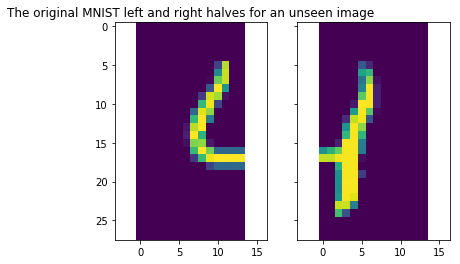

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.reshape(left_mnist.test.images[4], (28,14)))
ax1.set_title('The original MNIST left and right halves for an unseen image')
ax2.imshow(np.reshape(right_mnist.test.images[4], (28,14)))

## Reconstruction when both and right images are provided to the NN

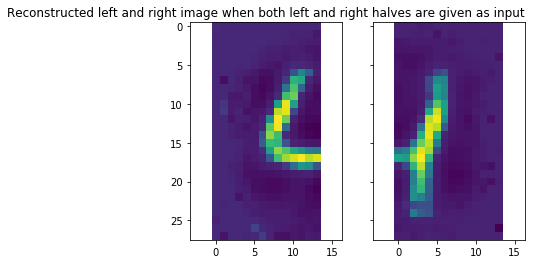

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.reshape(rec_left[4], (28,14)))
ax1.set_title('Reconstructed left and right image when both left and right halves are given as input')
ax2.imshow(np.reshape(rec_right[4], (28,14)))

## Self and cross reconstruction when only left image is provided

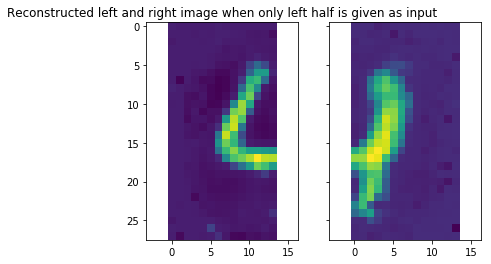

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.reshape(rec_left_left[4], (28,14)))
ax1.set_title('Reconstructed left and right image when only left half is given as input')
ax2.imshow(np.reshape(rec_left_right[4], (28,14)))

## Self and cross reconstruction when only right image is provided

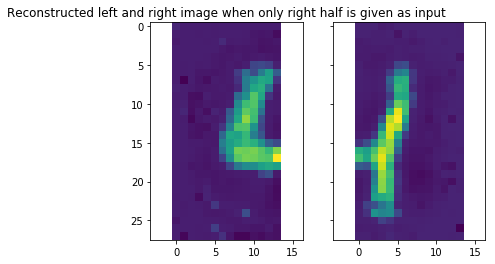

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.reshape(rec_right_left[4], (28,14)))
ax1.set_title('Reconstructed left and right image when only right half is given as input')
ax2.imshow(np.reshape(rec_right_right[4], (28,14)))

In [2]:
from tensorflow.python.framework import dtypes

In [24]:
with open('predicates.en.vec') as f:
    lines = [l.strip().split(' ') for l in f.readlines()]
    predicates2fasttext = {l[0]:[float(n) for n in l[1:]] for l in lines}

In [25]:
with open('classes.en.vec') as f:
    lines = [l.strip().split(' ') for l in f.readlines()]
    classes2fasttext = {l[0]:[float(n) for n in l[1:]] for l in lines}

In [26]:
classes2fasttext

{'antelope': [-0.10735,
  0.213,
  -0.40677,
  0.6455,
  -0.28117,
  0.11699,
  -0.22004,
  -0.10867,
  0.43015,
  0.29645,
  0.40471,
  0.16388,
  0.039436,
  -0.26032,
  0.11651,
  0.047437,
  -0.56656,
  -0.23073,
  -0.05488,
  0.19884,
  0.13214,
  0.23401,
  -0.48384,
  0.42787,
  -0.52784,
  -0.11383,
  0.037369,
  -0.073063,
  0.13372,
  -0.29859,
  -0.23482,
  0.31505,
  -0.38998,
  -0.44616,
  0.33469,
  -0.23026,
  0.17433,
  -0.27261,
  0.38628,
  -0.54056,
  0.1962,
  0.224,
  0.45023,
  0.083994,
  -0.028331,
  0.058802,
  0.071125,
  -0.26616,
  0.13207,
  0.033187,
  -0.0066753,
  0.15679,
  -0.2283,
  0.28185,
  -0.34399,
  0.33563,
  0.09671,
  -0.023915,
  -0.13161,
  0.53164,
  0.17907,
  -0.12519,
  0.43409,
  0.19609,
  0.04439,
  -0.14497,
  0.044367,
  0.012125,
  -0.16033,
  0.082526,
  0.1318,
  -0.18694,
  -0.0099215,
  -0.079828,
  -0.13001,
  -0.23385,
  0.5028,
  0.42326,
  -0.11531,
  -0.11076,
  -0.043783,
  -0.085622,
  -0.22315,
  0.1166,
  0.17779,
  0

In [5]:
with open('../mmfeat/Animals_with_Attributes2/predicates.txt') as f:
    lines = [l.strip().split('\t') for l in f.readlines()]
    predicates_in_order = [p[1] for p in lines]
    
with open('../mmfeat/Animals_with_Attributes2/classes.txt') as f:
    lines = [l.strip().split('\t') for l in f.readlines()]
    classes_in_order = [p[1] for p in lines]

In [6]:
classes_in_order

['antelope',
 'grizzly+bear',
 'killer+whale',
 'beaver',
 'dalmatian',
 'persian+cat',
 'horse',
 'german+shepherd',
 'blue+whale',
 'siamese+cat',
 'skunk',
 'mole',
 'tiger',
 'hippopotamus',
 'leopard',
 'moose',
 'spider+monkey',
 'humpback+whale',
 'elephant',
 'gorilla',
 'ox',
 'fox',
 'sheep',
 'seal',
 'chimpanzee',
 'hamster',
 'squirrel',
 'rhinoceros',
 'rabbit',
 'bat',
 'giraffe',
 'wolf',
 'chihuahua',
 'rat',
 'weasel',
 'otter',
 'buffalo',
 'zebra',
 'giant+panda',
 'deer',
 'bobcat',
 'pig',
 'lion',
 'mouse',
 'polar+bear',
 'collie',
 'walrus',
 'raccoon',
 'cow',
 'dolphin']

In [7]:
with open('../mmfeat/Animals_with_Attributes2/predicate-matrix-binary.txt') as f:
    predicate_matrix = [l.strip().split() for l in f.readlines()]

In [8]:
import itertools

zeros = [0 for _ in range(300)]
predicates_for_classes = {}
for class_idx in range(len(predicate_matrix)):
    curr_class = classes_in_order[class_idx]
    predicates_for_classes[curr_class] = np.zeros(300)
    for predicate_idx in range(len(predicate_matrix[class_idx])):
        curr_predicate = predicates_in_order[predicate_idx]
        if predicate_matrix[class_idx][predicate_idx] == '1':
            predicates_for_classes[curr_class] += predicates2fasttext[curr_predicate]
        else:
            predicates_for_classes[curr_class] += zeros
predicates_for_classes = {c: np.array(v) for c, v in predicates_for_classes.iteritems()}

In [15]:
import cPickle as pickle

In [16]:
with open('awa.pkl') as f:
    awa_embeddings = pickle.load(f)
    awa_embeddings = {k: v.values() for k, v in awa_embeddings.iteritems()}

In [17]:
from __future__ import absolute_import
from __future__ import division

import collections
import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import random_seed


Datasets = collections.namedtuple('Datasets', ['train', 'validation', 'test'])


class DataSet(object):

    def __init__(self,
                 embeddings,
                 labels,
                 fake_data=False,
                 one_hot=False,
                 dtype=dtypes.float32,
                 seed=None):
        """Construct a DataSet.
        one_hot arg is used only if fake_data is true.  `dtype` can be either
        `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
        `[0, 1]`.  Seed arg provides for convenient deterministic testing.
        """
        seed1, seed2 = random_seed.get_seed(seed)
        # If op level seed is not set, use whatever graph level seed
        # is returned
        np.random.seed(seed1 if seed is None else seed2)
        dtype = dtypes.as_dtype(dtype).base_dtype
        if dtype not in (dtypes.uint8, dtypes.float32):
            raise TypeError('Invalid image dtype {}, expected uint8 or float32'
                            .format(dtype))
        if fake_data:
            self._num_examples = 10000
            self.one_hot = one_hot
        else:
            assert embeddings.shape[0] == embeddings.shape[0], (
                'embeddings.shape: {} labels.shape: {}'
                .format(embeddings.shape, labels.shape))
            self._num_examples = embeddings.shape[0]

        self._embeddings = embeddings
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def embeddings(self):
        return self._embeddings

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size, fake_data=False, shuffle=False):
        """Return the next `batch_size` examples from this data set."""
        if fake_data:
            fake_image = [1] * 784
            if self.one_hot:
                fake_label = [1] + [0] * 9
            else:
                fake_label = 0
            return ([fake_image for _ in xrange(batch_size)],
                    [fake_label for _ in xrange(batch_size)])
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._embeddings = self.embeddings[perm0]
            self._labels = self.labels[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            embeddings_rest_part = self._embeddings[start:self._num_examples]
            labels_rest_part = self._labels[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._embeddings = self.embeddings[perm]
                self._labels = self.labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            embeddings_new_part = self._embeddings[start:end]
            labels_new_part = self._labels[start:end]
            concat_imgs = np.concatenate(
                (embeddings_rest_part, embeddings_new_part), axis=0)
            concat_labels = np.concatenate(
                (labels_rest_part, labels_new_part), axis=0)
            return concat_imgs, concat_labels
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._embeddings[start:end], self._labels[start:end]


In [34]:
image_embeddings = []
labels = []
predicate_embeddings = []
classes_embeddings = []
for cls in classes_in_order:
    image_embeddings += awa_embeddings[cls]
    labels += [cls for _ in range(len(awa_embeddings[cls]))]
    predicate_embeddings += [predicates_for_classes[cls] for _ in range(len(awa_embeddings[cls]))]
    classes_embeddings += [classes2fasttext[cls] for _ in range(len(awa_embeddings[cls]))]
    
awa = zip(image_embeddings, predicate_embeddings, classes_embeddings, labels)

import random

random.shuffle(awa)
image_embeddings, predicate_embeddings, classes_embeddings, labels = map(np.array, zip(*awa))

In [37]:
import corrnet.model

In [45]:
corrnet.model.build_encoder()